# 인공지능 팀 프로젝트

Title : Regression 알고리즘을 이용한 데이터 분석

Objective 1 : 중고차 가격 예측

Objective 2 : 보험료 가격 예측

# 보험료 가격 예측

In [19]:
from google.colab import drive
import os, sys
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [20]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Datasets

In [21]:
from __future__ import print_function
import os
data_path = ['/content/gdrive/MyDrive/Colab Notebooks/2022-AI-W13']

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler


In [22]:
import pandas as pd
import numpy as np

# Import the data using the file path
filepath = os.sep.join(data_path + ['expenses.csv'])
data = pd.read_csv(filepath, sep=',')

print(data.shape)

(1338, 7)


In [23]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [24]:
data.head(5).T

,0,1,2,3,4
age,19,18,28,33,32
sex,female,male,male,male,male
bmi,27.9,33.77,33.0,22.705,28.88
children,0,1,3,0,0
smoker,yes,no,no,no,no
region,southwest,southeast,southeast,northwest,northwest
charges,16884.924,1725.5523,4449.462,21984.47061,3866.8552


총 1338개의 데이터가 존재하며, 7개의 feature가 존재한다.

feature는 3개의 Categorical data와 4개의 numerical data로 이루어져 있다.

In [25]:
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [26]:
data['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [27]:
data['charges'].value_counts()

1639.56310     2
16884.92400    1
29330.98315    1
2221.56445     1
19798.05455    1
              ..
7345.08400     1
26109.32905    1
28287.89766    1
1149.39590     1
29141.36030    1
Name: charges, Length: 1337, dtype: int64

## 2. One-Hot Encoding

In [28]:
mask = data.dtypes == object
categorical_cols = data.columns[mask]
print(categorical_cols)

Index(['sex', 'smoker', 'region'], dtype='object')


In [29]:
data[categorical_cols]

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


categorical 데이터가 ordered data인지, unordered data인지에 따라서 인코딩 기법이 다르다. 

현재 상황에서는 'sex', 'smoker', 'region' 모두 순서가 있는 categorical data가 아니기 때문에 one-hot 인코딩을 수행한다.

In [30]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

5

In [31]:
# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [32]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

5

In [33]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

7
4


In [34]:
data_ohc.head()

,age,bmi,children,charges,region_0,region_1,region_2,region_3,sex_0,sex_1,smoker_0,smoker_1
0,19,27.900,0,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


중고 자동차 data와는 달리 string data들이 모두 유의미하다고 판단해 drop할 데이터는 따로 없다고 판단하였습니다.

## 3. Train & Test Split
- 학습용 데이터 셋과, 테스트용 데이터 셋을 7:3 비율로 나눈다.
- 먼저 simple linear regression을 적용해보고, 인코딩이 적절한지 확인한다.

In [39]:
y_col = 'charges'

seed = 70

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=seed)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=seed)

In [40]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

In [41]:
LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,1.310414e+08,3.538522e+07
test,1.243767e+08,3.933072e+07


실험 결과를 보면, one-hot 인코딩의 경우 train 성능은 좋지만, test 성능이 나쁜것을 알 수 있다. 

이는 overfitting이 발생했기 때문이다. 

Scaler기법을 적용하여 overfitting을 완화한다.

In [42]:
pd.options.mode.chained_assignment = None

In [43]:
scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        1.243767e+08
not_encoded - minmaxscaling          1.243767e+08
not_encoded - maxabsscaling          1.243767e+08
one_hot_encoded - standardscaling    3.933072e+07
one_hot_encoded - minmaxscaling      3.933072e+07
one_hot_encoded - maxabsscaling      3.933072e+07
--------------------------------------------------------------------------------
not_encoded - standardscaling 124376722.02469668
not_encoded - minmaxscaling 124376722.02469665
not_encoded - maxabsscaling 124376722.02469665
one_hot_encoded - standardscaling 39330717.057002954
one_hot_encoded - minmaxscaling 39330717.05700298
one_hot_encoded - maxabsscaling 39330717.05700298


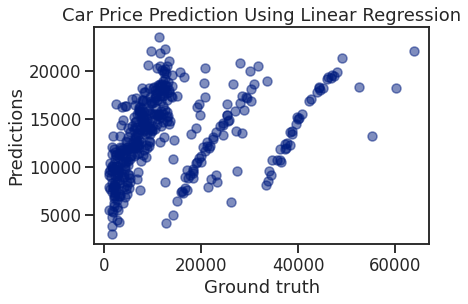

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Car Price Prediction Using Linear Regression');

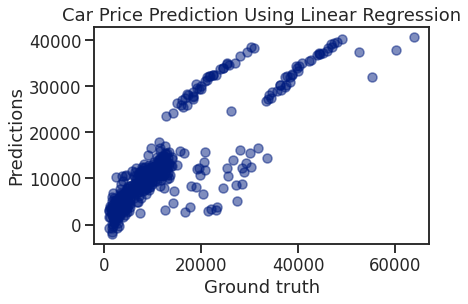

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test_ohc, y_test_ohc_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Car Price Prediction Using Linear Regression');

Lasso

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [47]:
data.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [48]:
data_ohc.head()

,age,bmi,children,charges,region_0,region_1,region_2,region_3,sex_0,sex_1,smoker_0,smoker_1
0,19,27.900,0,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


124376722.03572534
39330717.0112961


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e+09, tolerance: 1.380e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0, flags=flags)


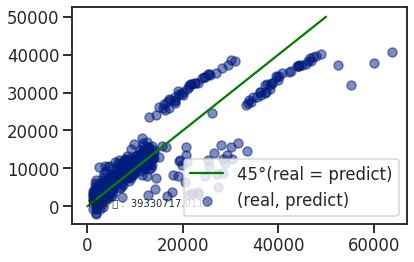

In [52]:
from sklearn.linear_model import Lasso

alpha=0.00001
lassor = Lasso(alpha)

lassor = lassor.fit(X_train, y_train)
y_test_lasso = lassor.predict(X_test)
print( mean_squared_error(y_test, y_test_lasso))

lassor_ohc = Lasso(alpha)

lassor_ohc = lassor.fit(X_train_ohc, y_train_ohc)
y_test_lasso_ohc = lassor.predict(X_test_ohc)
print( mean_squared_error(y_test_ohc, y_test_lasso_ohc))

plt.scatter(y_test_ohc,y_test_lasso_ohc, label = '(real, predict)', alpha=.5)
plt.plot(np.linspace(0,50000,200), np.linspace(0,50000,200), color = 'green', label = "45°(real = predict)")
plt.legend()
plt.text(y=0,x=35, s=f'MSE 값 : {mean_squared_error(y_test_ohc,y_test_lasso_ohc) : .4f}')
plt.show()


In [53]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))
alphas2 = np.array([0.0001])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
rmse_vals = [linearRegression_rmse, lassoCV_rmse]
labels = ['Linear', 'Lasso']
rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Import SGDRegressor and prepare the parameters
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD
Linear,11152.431216,4.280398e+09
Lasso,11152.431221,3.740640e+10


One hot encoding


보험료 예측 data의 경우엔 car data와는 달리 너무 다양하거나 편향된 데이터가 없었기에, 모든 데이터를 drop하지 않고 사용하였다.
보험 data의 경우 특히 one hot encoding의 효과를 많이 봤는데, 이를 고려하면 string data가 결과에 유의미하게 영향을 미치는 경우가 car data보다 더 많았다고 판단됩니다.

Scaler

Scaling의 경우, Maxabsscaler, MinMaxScaler와 StandardScaler를 현재 주어진 데이터로만 단순히 비교했을 땐 StandardScaler가 더 나은 성능을 보여주었다. 하지만 성능 개선에 있어 유의미한 향상효과를 볼 수는 없다고 판단된다. 그 이유로는 KNN의 경우엔 거리 측정 방법에 따라 결정값이 변화하기 때문에 정확도에 더 유의미한 차이를 유발할 수 있지만, Linear Regression의 경우엔 데이터 분포 정도 보다는 데이터 분포 양상이 더 중요하게 영향을 미친다고 생각된다. 특히 one hot encoding을 한 경우 데이터의 선형적 분포양상이 더 분명하게 드러난 것을 확인 할 수 있었다.

Lasso

Lasso regression을 진행 한 경우가 미세하게 오차를 줄인 효과를 얻을 수 있었다. 하지만 Scaling과 유사하게 성능개선에 큰 영향을 미쳤다고는 보기 힘든 것 같다. 그 이유로는 이미 데이터들이 선형으로 분포된 경향이 있으며, 선형 관계에서 벗어난 데이터가 적어서, 특정 데이터들로 인해 발생하는 오차를 줄이기 위한 overfitting이 적게 발생하였다고 생각된다. 때문에 overfitting을 줄이는 Lasso regression의 효과 또한 크게 영향을 미치지는 못했지만 미미하게나마 발생한 overfitting을 줄여주었다고 생각된다.